# Beta calibration

## Introduction

Logistic calibration is designed to correct for a specific kind of distortion where classifiers tend to score on too narrow a scale. However, many classifiers including Naive Bayes and standard Adaboost suffer from the opposite distortion where scores tend too much to the extremes. 

In this tutorial, we will motivate Beta calibration and our betacal Python package.

## Probability estimation with Adaboost

First, let's train an Adaboost model with 200 decision stumps to estimate class probabilities for the well-known spam dataset. The dataset will be divided into a training set (50%), a test set (25%) and a calibration set (25%). The classifier will be trained on the training set and we'll estimate class probabilities for the test set.


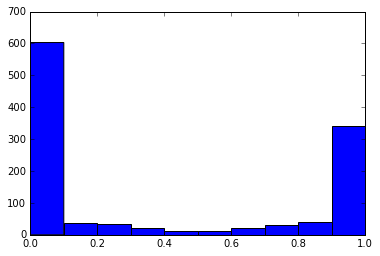

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from adaboost import AdaBoostClassifier

np.random.seed(42)

data = np.genfromtxt('spambase.data', delimiter=',')
target = data[:,-1]
data = data[:,0:-1]

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.5, stratify=target)
x_cal, x_test, y_cal, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

ada = AdaBoostClassifier(n_estimators=200)
ada = ada.fit(x_train, y_train)
probas = ada.predict_proba(x_test)

plt.clf()
plt.hist(probas[:,1])
plt.show()

## Calibrating the scores

We can clearly see from the histogram that the probabilities produced by the model tend to assume extreme values. Therefore, it might be useful to apply calibration techniques to try and fix these distortions. Two calibration methods have been widely used in machine learning literature: logistic calibration and isotonic regression. The first one is a parametric method that assumes an underlying distribution of the scores composed of two Gaussians of equal variance, (one for the positives and another for the negatives). The second method is a non-parametric approach, therefore it doesn't make any assumption about the distribution of the scores, however, it needs lots of data to produce a good model. Let's see the effect of applying these methods to the previously trained classifier's outputs.

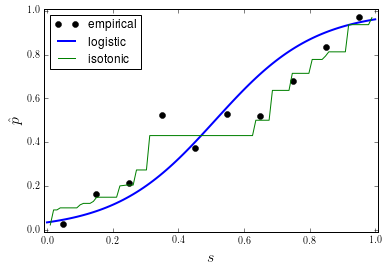

In [2]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from calmap import plot_calibration_map

cal_probas = ada.predict_proba(x_cal)[:, 1]

lr = LogisticRegression(C=99999999999)
lr.fit(cal_probas.reshape(-1, 1), y_cal)

iso = IsotonicRegression()
iso.fit(cal_probas, y_cal)

linspace = np.linspace(0, 1, 100)
pr = [lr.predict_proba(linspace.reshape(-1, 1))[:, 1], iso.predict(linspace)]
idx = cal_probas.argsort()
scores = cal_probas[idx]
y_c_2 = y_cal[idx]
methods_text = ['logistic', 'isotonic']
fig_map = plot_calibration_map(pr, [scores, y_c_2, linspace], methods_text, alpha=0)

## Calibration map

In the calibration map shown above, we can see that:

* Logistic calibration fit the scores in the first and last bins well, but was either underconfident or overconfident in the rest of the map, due to the limitations of its shape
* As a non-parametric method, Isotonic regression managed to fit the scores better than Logistic calibration by finding an inverted sigmoid shape

## Fitting a beta calibration model with the betacal package

Our beta calibration is a parametric method which is able to circumvent logistic calibration's shape limitations by fitting three parameters, i.e. two for shape (a and b) and one for location (m). These parameters can be fitted by training a logistic regression model with two features extracted from the classifier's probability outputs. Beta calibration is adequate for calibrating probabilities, because the beta distribution has support [0, 1], while logistic calibration assumes the scores are distributed in two gaussians, which have infinite support.

To make it easy for practitioners to fit a beta calibration model, we have provided a Python package called __betacal__. The package can be installed via pip (_pip install betacal_). Below, we show how to use the package to fit the three-parameter version of beta calibration. For the other two versions, the practitioner can set parameters="ab" (fit shape parameters a and b and fix location parameter m = 0.5) or parameters="am" (fit shape parameter a, setting a = b, and fit location parameter m).

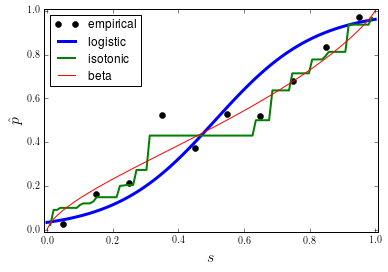

In [3]:
from betacal import BetaCalibration

# Fit three-parameter beta calibration
bc = BetaCalibration(parameters="abm")
bc.fit(cal_probas.reshape(-1, 1), y_cal)

pr = [lr.predict_proba(linspace.reshape(-1, 1))[:, 1], iso.predict(linspace), bc.predict(linspace)]
methods_text = ['logistic', 'isotonic', 'beta']
fig_map = plot_calibration_map(pr, [scores, y_c_2, linspace], methods_text, alpha=0)

Beta calibration was able to find the inverted sigmoid shape, as isotonic regression did, resulting in a much better fit for the scores than logistic calibration. Now let's see what happens when a classifier outputs probabilities that tend to be concentrated around mean values.

## Probability estimation with logistic regression

Below, we train a logistic regression using the same spam dataset. We can see that its probability outputs are concentrated around 0.5. This distortion is what logistic calibration works on best.

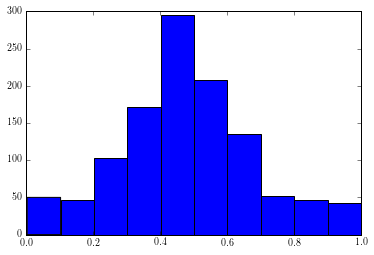

In [4]:
lrc = LogisticRegression(C=0.001)
lrc = lrc.fit(x_train, y_train)
probas_lrc = lrc.predict_proba(x_test)

plt.clf()
plt.hist(probas_lrc[:,1])
plt.show()

Now let's train the calibration models.

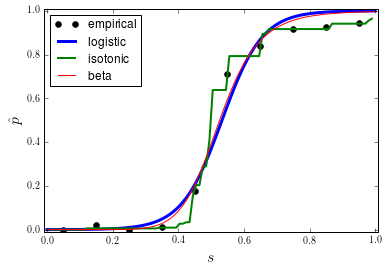

In [5]:
cal_probas_lrc = lrc.predict_proba(x_cal)[:, 1]

lr = LogisticRegression(C=99999999999)
lr.fit(cal_probas_lrc.reshape(-1, 1), y_cal)

iso = IsotonicRegression()
iso.fit(cal_probas_lrc, y_cal)

bc = BetaCalibration(parameters="abm")
bc.fit(cal_probas_lrc.reshape(-1, 1), y_cal)

pr = [lr.predict_proba(linspace.reshape(-1, 1))[:, 1], iso.predict(linspace), bc.predict(linspace)]
methods_text = ['logistic', 'isotonic', 'beta']
idx = cal_probas_lrc.argsort()
scores = cal_probas_lrc[idx]
y_c_2 = y_cal[idx]
fig_map = plot_calibration_map(pr, [scores, y_c_2, linspace], methods_text, alpha=0)

Notice how all three methods find sigmoid shapes. This is because the sigmoid shape is part of the beta calibration family, which also contains an identity calibration map, which just keeps the scores with their original values (this is not possible with logistic calibration). In both maps, isotonic regression did a great job fitting the scores, but as a non-parametric method, it needs a lot of data to train (as is the case with the spam dataset), which is not a problem for beta calibration. Therefore, given that beta calibration is able to fit the classifier's output probabilities better than or at least equal to logistic calibration, we argue that a practicioner who wants to use a parametric calibration method should choose beta calibration.